In [2]:
import numpy as np
import torch
import torch.optim
import torch.nn as nn
import torch.nn.functional as F
from tensorflow.keras.datasets import cifar10 # to load dataset

from utils import compute_stats, get_grad
from MB_LBFGS import LBFGS
import SGD_BB

import matplotlib.pyplot as plt
plt.style.use('seaborn-paper')
from time import time
from tqdm import notebook

import pandas as pd

In [3]:
max_iter = 15 * (50000 // 256)  # epochs
ghost_batch = 128
overlap_ratio = 0.25  # should be in (0, 0.5)
lr = 1.0

In [4]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train = X_train/255
X_test = X_test/255

X_train = np.transpose(X_train, (0, 3, 1, 2))
X_test = np.transpose(X_test, (0, 3, 1, 2))

In [4]:
X_train.shape, X_test.shape

((50000, 3, 32, 32), (10000, 3, 32, 32))

In [5]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 1000)
        self.fc2 = nn.Linear(1000, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [6]:
cuda = torch.cuda.is_available()
    
#%% Create neural network model
        
if(cuda):
    torch.cuda.manual_seed(2018)
    model = ConvNet().cuda() 
else:
    torch.manual_seed(2018)
    model = ConvNet()
    
#%% Define helper functions

# Forward pass
if(cuda):
    opfun = lambda X: model.forward(torch.from_numpy(X).cuda())
else:
    opfun = lambda X: model.forward(torch.from_numpy(X))

# Forward pass through the network given the input
if(cuda):
    predsfun = lambda op: np.argmax(op.cpu().data.numpy(), 1)
else:
    predsfun = lambda op: np.argmax(op.data.numpy(), 1)

# Do the forward pass, then compute the accuracy
accfun   = lambda op, y: np.mean(np.equal(predsfun(op), y.squeeze()))*100

In [7]:
train_losses = {}
val_losses = {}
val_accs = {}
times = {}

In [8]:
batch_size = 256
optimizer = LBFGS(model.parameters(), lr=lr, history_size=10, line_search='None', debug=True)
epoch = 0

opt_name = 'LBFGS'
train_losses[opt_name] = []
val_losses[opt_name] = []
val_accs[opt_name] = []
#%% Main training loop

Ok_size = int(overlap_ratio*batch_size)
Nk_size = int((1 - 2*overlap_ratio)*batch_size)

# sample previous overlap gradient
random_index = np.random.permutation(range(X_train.shape[0]))
Ok_prev = random_index[0:Ok_size]
g_Ok_prev, obj_Ok_prev = get_grad(optimizer, X_train[Ok_prev], y_train[Ok_prev], opfun)

time0 = time()

for n_iter in notebook.tqdm(range(max_iter)):
    
    # sample current non-overlap and next overlap gradient
    random_index = np.random.permutation(range(X_train.shape[0]))
    Ok = random_index[0:Ok_size]
    Nk = random_index[Ok_size:(Ok_size + Nk_size)]
    
    # compute overlap gradient and objective
    g_Ok, obj_Ok = get_grad(optimizer, X_train[Ok], y_train[Ok], opfun)
    
    # compute non-overlap gradient and objective
    g_Nk, obj_Nk = get_grad(optimizer, X_train[Nk], y_train[Nk], opfun)
    
    # compute accumulated gradient over sample
    g_Sk = overlap_ratio*(g_Ok_prev + g_Ok) + (1 - 2*overlap_ratio)*g_Nk
        
    # two-loop recursion to compute search direction
    p = optimizer.two_loop_recursion(-g_Sk)
                
    # perform line search step
    lr = optimizer.step(p, g_Ok, g_Sk=g_Sk)
    
    # compute previous overlap gradient for next sample
    Ok_prev = Ok
    g_Ok_prev, obj_Ok_prev = get_grad(optimizer, X_train[Ok_prev], y_train[Ok_prev], opfun)
    
    # curvature update
    optimizer.curvature_update(g_Ok_prev, eps=0.2, damping=True)
    
    # compute statistics
    if n_iter % (50000 // 256) == 0:
        epoch += 1
        with torch.no_grad():
            train_loss, test_loss, test_acc = compute_stats(X_train, y_train, X_test, 
                                                            y_test, opfun, accfun, ghost_batch=128)
            train_losses[opt_name].append(train_loss)
            val_losses[opt_name].append(test_loss)
            val_accs[opt_name].append(test_acc)
            print('Epoch:', epoch, 'lr:', lr, 'Training Loss:', train_loss, 
                  'Test Loss:', test_loss, 'Test Accuracy:', test_acc)
            
times[opt_name] = (time()-time0)/60

Epoch: 1 lr: 1.0 Training Loss: 2.30356067080021 Test Loss: 2.3032887613534934 Test Accuracy: 10.1
Applying Powell damping...
Applying Powell damping...
Applying Powell damping...
Applying Powell damping...
Epoch: 2 lr: 1.0 Training Loss: 1.7289709778523448 Test Loss: 1.7246136313438418 Test Accuracy: 37.11000000000002
Applying Powell damping...
Epoch: 3 lr: 1.0 Training Loss: 1.667931826069355 Test Loss: 1.6625361763000492 Test Accuracy: 39.85999999999999
Epoch: 4 lr: 1.0 Training Loss: 1.6192266919755938 Test Loss: 1.618108734953403 Test Accuracy: 41.40000000000001
Epoch: 5 lr: 1.0 Training Loss: 1.5936238630771635 Test Loss: 1.5944948432803154 Test Accuracy: 42.39
Epoch: 6 lr: 1.0 Training Loss: 1.5680413751578326 Test Loss: 1.5689392360687253 Test Accuracy: 43.239999999999995
Epoch: 7 lr: 1.0 Training Loss: 1.5329451598834993 Test Loss: 1.5382447044968601 Test Accuracy: 44.570000000000014
Epoch: 8 lr: 1.0 Training Loss: 1.5201753351092346 Test Loss: 1.5262847236871722 Test Accuracy

In [9]:
cuda = torch.cuda.is_available()
    
#%% Create neural network model
        
if(cuda):
    torch.cuda.manual_seed(2018)
    model = ConvNet().cuda() 
else:
    torch.manual_seed(2018)
    model = ConvNet()
    
#%% Define helper functions

# Forward pass
if(cuda):
    opfun = lambda X: model.forward(torch.from_numpy(X).cuda())
else:
    opfun = lambda X: model.forward(torch.from_numpy(X))

# Forward pass through the network given the input
if(cuda):
    predsfun = lambda op: np.argmax(op.cpu().data.numpy(), 1)
else:
    predsfun = lambda op: np.argmax(op.data.numpy(), 1)

# Do the forward pass, then compute the accuracy
accfun   = lambda op, y: np.mean(np.equal(predsfun(op), y.squeeze()))*100

In [10]:
batch_size = 256
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epoch = 0

opt_name = 'Adam'
train_losses[opt_name] = []
val_losses[opt_name] = []
val_accs[opt_name] = []

time0 = time()
for n_iter in notebook.tqdm(range(max_iter)):
    
    # sample current non-overlap and next overlap gradient
    random_index = np.random.permutation(range(X_train.shape[0]))
    idx = random_index[0:batch_size]
    optimizer.zero_grad()
    
    X_batch = torch.from_numpy(X_train[idx])
    y_batch = torch.from_numpy(y_train[idx]).long().squeeze()
    
    loss = F.cross_entropy(model(X_batch), y_batch)
    loss.backward()
    
    optimizer.step()
    
    # compute statistics
    if n_iter % (50000 // 256) == 0:
        epoch += 1
        with torch.no_grad():
            train_loss, test_loss, test_acc = compute_stats(X_train,
                                                            y_train,
                                                            X_test, 
                                                            y_test,
                                                            opfun,
                                                            accfun,
                                                            ghost_batch=128)
            train_losses[opt_name].append(train_loss)
            val_losses[opt_name].append(test_loss)
            val_accs[opt_name].append(test_acc)
            
            print('Epoch:', epoch, 'lr:', lr, 'Training Loss:', train_loss, 
                  'Test Loss:', test_loss, 'Test Accuracy:', test_acc)
times[opt_name] = (time()-time0)/60

Epoch: 1 lr: 1.0 Training Loss: 2.2981539660167685 Test Loss: 2.2981751600027085 Test Accuracy: 12.299999999999999
Epoch: 2 lr: 1.0 Training Loss: 1.5752585729360578 Test Loss: 1.5818986895322802 Test Accuracy: 42.42000000000001
Epoch: 3 lr: 1.0 Training Loss: 1.4580406972622872 Test Loss: 1.4722835295557979 Test Accuracy: 45.529999999999994
Epoch: 4 lr: 1.0 Training Loss: 1.4160330706048012 Test Loss: 1.435216797709465 Test Accuracy: 48.08000000000001
Epoch: 5 lr: 1.0 Training Loss: 1.2804536474585537 Test Loss: 1.3127832109212876 Test Accuracy: 52.07000000000002
Epoch: 6 lr: 1.0 Training Loss: 1.222648081653118 Test Loss: 1.2697500843048095 Test Accuracy: 54.82
Epoch: 7 lr: 1.0 Training Loss: 1.223945415728092 Test Loss: 1.2787992852687837 Test Accuracy: 54.34000000000002
Epoch: 8 lr: 1.0 Training Loss: 1.1433374844145772 Test Loss: 1.2184730343222616 Test Accuracy: 57.15000000000001
Epoch: 9 lr: 1.0 Training Loss: 1.094713022663593 Test Loss: 1.186475141906738 Test Accuracy: 57.7299

In [11]:
cuda = torch.cuda.is_available()
    
#%% Create neural network model
        
if(cuda):
    torch.cuda.manual_seed(2018)
    model = ConvNet().cuda() 
else:
    torch.manual_seed(2018)
    model = ConvNet()
    
#%% Define helper functions

# Forward pass
if(cuda):
    opfun = lambda X: model.forward(torch.from_numpy(X).cuda())
else:
    opfun = lambda X: model.forward(torch.from_numpy(X))

# Forward pass through the network given the input
if(cuda):
    predsfun = lambda op: np.argmax(op.cpu().data.numpy(), 1)
else:
    predsfun = lambda op: np.argmax(op.data.numpy(), 1)

# Do the forward pass, then compute the accuracy
accfun   = lambda op, y: np.mean(np.equal(predsfun(op), y.squeeze()))*100

In [12]:
batch_size = 256
optimizer = torch.optim.SGD(model.parameters(), 
                            lr=0.003)

epoch = 0

opt_name = 'SGD'
train_losses[opt_name] = []
val_losses[opt_name] = []
val_accs[opt_name] = []

time0 = time()
for n_iter in notebook.tqdm(range(max_iter)):
    
    # sample current non-overlap and next overlap gradient
    random_index = np.random.permutation(range(X_train.shape[0]))
    idx = random_index[0:batch_size]
    optimizer.zero_grad()
    
    X_batch = torch.from_numpy(X_train[idx])
    y_batch = torch.from_numpy(y_train[idx]).long().squeeze()
    
    loss = F.cross_entropy(model(X_batch), y_batch)
    loss.backward()
    
    optimizer.step()
    
    # compute statistics
    if n_iter % (50000 // 256) == 0:
        epoch += 1
        with torch.no_grad():
            train_loss, test_loss, test_acc = compute_stats(X_train,
                                                            y_train,
                                                            X_test, 
                                                            y_test,
                                                            opfun,
                                                            accfun,
                                                            ghost_batch=128)
            train_losses[opt_name].append(train_loss)
            val_losses[opt_name].append(test_loss)
            val_accs[opt_name].append(test_acc)
            
            print('Epoch:', epoch, 'lr:', lr, 'Training Loss:', train_loss, 
                  'Test Loss:', test_loss, 'Test Accuracy:', test_acc)
times[opt_name] = (time()-time0)/60

Epoch: 1 lr: 1.0 Training Loss: 2.3029131884431826 Test Loss: 2.3028744561910623 Test Accuracy: 10.500000000000002
Epoch: 2 lr: 1.0 Training Loss: 2.3009741069221494 Test Loss: 2.300917190647126 Test Accuracy: 12.410000000000004
Epoch: 3 lr: 1.0 Training Loss: 2.2990652892971046 Test Loss: 2.2989845547437664 Test Accuracy: 11.190000000000003
Epoch: 4 lr: 1.0 Training Loss: 2.2965232442378993 Test Loss: 2.296403614544868 Test Accuracy: 10.26
Epoch: 5 lr: 1.0 Training Loss: 2.2930546901941296 Test Loss: 2.2928875444412236 Test Accuracy: 10.060000000000004
Epoch: 6 lr: 1.0 Training Loss: 2.2885419926166537 Test Loss: 2.2883283851861953 Test Accuracy: 10.280000000000005
Epoch: 7 lr: 1.0 Training Loss: 2.2827400962305067 Test Loss: 2.2825131636381144 Test Accuracy: 11.07
Epoch: 8 lr: 1.0 Training Loss: 2.274865065779687 Test Loss: 2.2746725495100026 Test Accuracy: 12.970000000000004
Epoch: 9 lr: 1.0 Training Loss: 2.2638893757247924 Test Loss: 2.2637834838867192 Test Accuracy: 14.6700000000

In [13]:
cuda = torch.cuda.is_available()
    
#%% Create neural network model
        
if(cuda):
    torch.cuda.manual_seed(2018)
    model = ConvNet().cuda() 
else:
    torch.manual_seed(2018)
    model = ConvNet()
    
#%% Define helper functions

# Forward pass
if(cuda):
    opfun = lambda X: model.forward(torch.from_numpy(X).cuda())
else:
    opfun = lambda X: model.forward(torch.from_numpy(X))

# Forward pass through the network given the input
if(cuda):
    predsfun = lambda op: np.argmax(op.cpu().data.numpy(), 1)
else:
    predsfun = lambda op: np.argmax(op.data.numpy(), 1)

# Do the forward pass, then compute the accuracy
accfun   = lambda op, y: np.mean(np.equal(predsfun(op), y.squeeze()))*100

In [14]:
batch_size = 256
optimizer = torch.optim.SGD(model.parameters(), 
                              lr=0.003, 
                              momentum=0.9)

epoch = 0

opt_name = 'SGD with momentum'
train_losses[opt_name] = []
val_losses[opt_name] = []
val_accs[opt_name] = []

time0 = time()
for n_iter in notebook.tqdm(range(max_iter)):
    
    # sample current non-overlap and next overlap gradient
    random_index = np.random.permutation(range(X_train.shape[0]))
    idx = random_index[0:batch_size]
    optimizer.zero_grad()
    
    X_batch = torch.from_numpy(X_train[idx])
    y_batch = torch.from_numpy(y_train[idx]).long().squeeze()
    
    loss = F.cross_entropy(model(X_batch), y_batch)
    loss.backward()
    
    optimizer.step()
    
    # compute statistics
    if n_iter % (50000 // 256) == 0:
        epoch += 1
        with torch.no_grad():
            train_loss, test_loss, test_acc = compute_stats(X_train,
                                                            y_train,
                                                            X_test, 
                                                            y_test,
                                                            opfun,
                                                            accfun,
                                                            ghost_batch=128)
            train_losses[opt_name].append(train_loss)
            val_losses[opt_name].append(test_loss)
            val_accs[opt_name].append(test_acc)
            
            print('Epoch:', epoch, 'lr:', lr, 'Training Loss:', train_loss, 
                  'Test Loss:', test_loss, 'Test Accuracy:', test_acc)
times[opt_name] = (time()-time0)/60

Epoch: 1 lr: 1.0 Training Loss: 2.302913259634972 Test Loss: 2.3028740117788313 Test Accuracy: 10.490000000000002
Epoch: 2 lr: 1.0 Training Loss: 2.2568765308237078 Test Loss: 2.2568663368701944 Test Accuracy: 14.140000000000006
Epoch: 3 lr: 1.0 Training Loss: 1.993168178217411 Test Loss: 1.9892813722729683 Test Accuracy: 29.169999999999995
Epoch: 4 lr: 1.0 Training Loss: 1.8223336982965466 Test Loss: 1.8174505897521973 Test Accuracy: 35.380000000000024
Epoch: 5 lr: 1.0 Training Loss: 1.7019214259719853 Test Loss: 1.7001263500094415 Test Accuracy: 39.43000000000002
Epoch: 6 lr: 1.0 Training Loss: 1.6264018894028658 Test Loss: 1.6264789259910584 Test Accuracy: 42.36
Epoch: 7 lr: 1.0 Training Loss: 1.566236004316807 Test Loss: 1.5673678165793419 Test Accuracy: 43.84999999999999
Epoch: 8 lr: 1.0 Training Loss: 1.5354724740862848 Test Loss: 1.5351230256319037 Test Accuracy: 44.75000000000001
Epoch: 9 lr: 1.0 Training Loss: 1.4809225459718705 Test Loss: 1.4875955249190334 Test Accuracy: 46.

In [15]:
cuda = torch.cuda.is_available()
    
#%% Create neural network model
        
if(cuda):
    torch.cuda.manual_seed(2018)
    model = ConvNet().cuda() 
else:
    torch.manual_seed(2018)
    model = ConvNet()
    
#%% Define helper functions

# Forward pass
if(cuda):
    opfun = lambda X: model.forward(torch.from_numpy(X).cuda())
else:
    opfun = lambda X: model.forward(torch.from_numpy(X))

# Forward pass through the network given the input
if(cuda):
    predsfun = lambda op: np.argmax(op.cpu().data.numpy(), 1)
else:
    predsfun = lambda op: np.argmax(op.data.numpy(), 1)

# Do the forward pass, then compute the accuracy
accfun   = lambda op, y: np.mean(np.equal(predsfun(op), y.squeeze()))*100

In [16]:
batch_size = 256
optimizer = BB_DL.BB(model.parameters(), 
                     lr=0.003, 
                     steps=50000//256, 
                     beta=4. / (50000//256), 
                     max_lr=1, min_lr=1e-5)

epoch = 0

opt_name = 'BB'
train_losses[opt_name] = []
val_losses[opt_name] = []
val_accs[opt_name] = []

time0 = time()
for n_iter in notebook.tqdm(range(max_iter)):
    
    # sample current non-overlap and next overlap gradient
    random_index = np.random.permutation(range(X_train.shape[0]))
    idx = random_index[0:batch_size]
    optimizer.zero_grad()
    
    X_batch = torch.from_numpy(X_train[idx])
    y_batch = torch.from_numpy(y_train[idx]).long().squeeze()
    
    loss = F.cross_entropy(model(X_batch), y_batch)
    loss.backward()
    
    optimizer.step()
    
    # compute statistics
    if n_iter % (50000 // 256) == 0:
        epoch += 1
        with torch.no_grad():
            train_loss, test_loss, test_acc = compute_stats(X_train,
                                                            y_train,
                                                            X_test, 
                                                            y_test,
                                                            opfun,
                                                            accfun,
                                                            ghost_batch=128)
            train_losses[opt_name].append(train_loss)
            val_losses[opt_name].append(test_loss)
            val_accs[opt_name].append(test_acc)
            
            print('Epoch:', epoch, 'lr:', lr, 'Training Loss:', train_loss, 
                  'Test Loss:', test_loss, 'Test Accuracy:', test_acc)
times[opt_name] = (time()-time0)/60

Epoch: 1 lr: 1.0 Training Loss: 2.30291432094574 Test Loss: 2.302875495791436 Test Accuracy: 10.499999999999998
Epoch: 2 lr: 1.0 Training Loss: 2.300956861701011 Test Loss: 2.300892820048332 Test Accuracy: 12.470000000000002
Epoch: 3 lr: 1.0 Training Loss: 2.2989045812177653 Test Loss: 2.2988112341880798 Test Accuracy: 10.790000000000003
Epoch: 4 lr: 1.0 Training Loss: 2.27043391804695 Test Loss: 2.2701918823480605 Test Accuracy: 13.440000000000005
Epoch: 5 lr: 1.0 Training Loss: 2.068001113581657 Test Loss: 2.067152085876465 Test Accuracy: 28.98
Epoch: 6 lr: 1.0 Training Loss: 1.9956540934252742 Test Loss: 1.9897990244746206 Test Accuracy: 29.050000000000008
Epoch: 7 lr: 1.0 Training Loss: 1.881518649837971 Test Loss: 1.8785567377090457 Test Accuracy: 33.46
Epoch: 8 lr: 1.0 Training Loss: 1.6127138345074656 Test Loss: 1.6213302143454547 Test Accuracy: 42.000000000000014
Epoch: 9 lr: 1.0 Training Loss: 1.5419793004107476 Test Loss: 1.5599504906773565 Test Accuracy: 43.53999999999999
Ep

In [17]:
def plot_train_losses(losses):
    with plt.style.context('seaborn-paper'):
        f = plt.figure(figsize=(10,10))
        for opt in losses.keys():
            plt.plot(np.arange(len(losses[opt])) + 1, losses[opt], '--o', label=opt, linewidth=7)
        plt.xticks(np.arange(len(losses['SGD'])) + 1, size=20)
        plt.yticks(size=20)
        plt.legend(fontsize=30)
        plt.title('Epoch Loss on CIFAR-10 Train set', fontsize=30)
        plt.xlabel('Epoch', size=24)
        plt.ylabel('Loss', size=24)
        plt.grid()
    plt.show()
    f.savefig("/results/cifar_train_losses.pdf", bbox_inches='tight')


def plot_val_losses(losses):
    with plt.style.context('seaborn-paper'):
        f = plt.figure(figsize=(10,10))
        for opt in losses.keys():
            plt.plot(np.arange(len(losses[opt])) + 1, losses[opt], '--o' , label=opt, linewidth=7)
        plt.xticks(np.arange(len(losses['SGD'])) + 1, size=20)
        plt.yticks(size=20)
        plt.legend(fontsize=30)
        plt.title('Epoch Loss on CIFAR-10 Validation set', fontsize=30)
        plt.xlabel('Epoch', size=24)
        plt.ylabel('Loss', size=24)
        plt.grid()
    plt.show()
    f.savefig("/results/cifar_val_losses.pdf", bbox_inches='tight')
    

def plot_val_accuracy(accs):
    with plt.style.context('seaborn-paper'):
        f = plt.figure(figsize=(10,10))
        for opt in accs.keys():
            plt.plot(np.arange(len(accs[opt])) + 1, accs[opt], '--o', label=opt, linewidth=7)
        plt.xticks(np.arange(len(accs['SGD'])) + 1, size=20)
        plt.yticks(size=20)
        plt.legend(fontsize=30)
        plt.title('Epoch Accuracy on CIFAR-10 Validation set', fontsize=25)
        plt.xlabel('Epoch', size=24)
        plt.ylabel('Accuracy, %', size=24)
        plt.grid()
    plt.show()
    f.savefig("/results/cifar_val_accuracy.pdf", bbox_inches='tight')

In [51]:
train_losses['SGD-momentum'] = train_losses['SGD with momentum']
train_losses.pop('SGD with momentum')
val_losses['SGD-momentum'] = val_losses['SGD with momentum']
val_losses.pop('SGD with momentum')
val_accs['SGD-momentum'] = val_accs['SGD with momentum']
val_accs.pop('SGD with momentum')
times['SGD-momentum'] = times['SGD with momentum']
times.pop('SGD with momentum')

5.4027294516563416

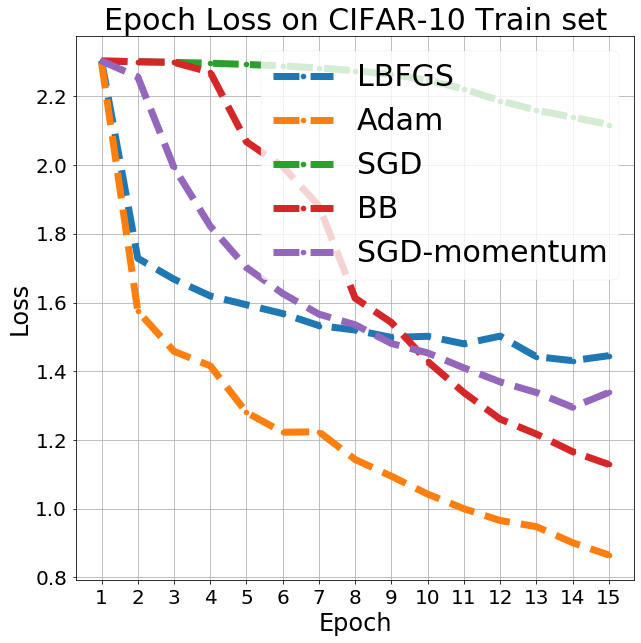

In [52]:
plot_train_losses(train_losses)

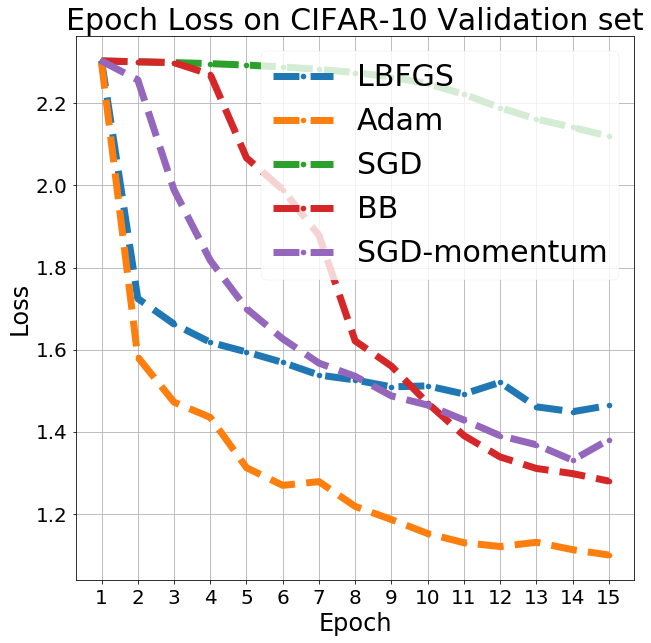

In [53]:
plot_val_losses(val_losses)

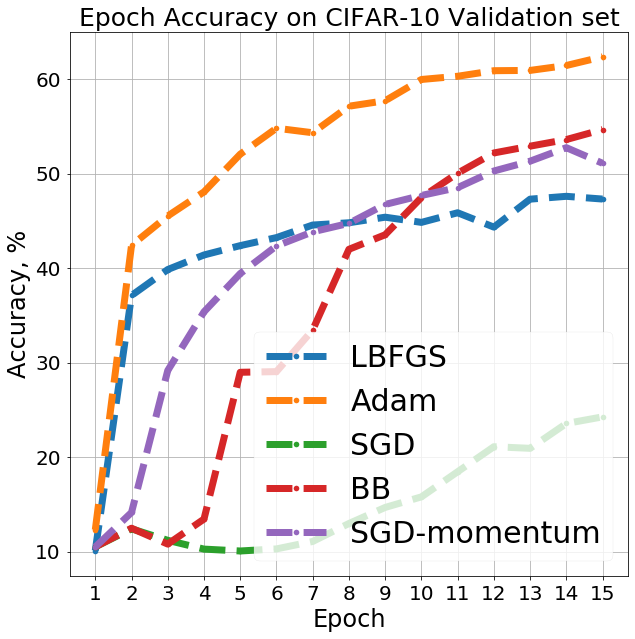

In [54]:
plot_val_accuracy(val_accs)

In [55]:
t = pd.DataFrame()
t['Optimizer'] = times.keys()
t['Time'] = times.values()
t['Acc 5'] = np.array(list(val_accs.values()))[:,4]
t['Acc 10'] = np.array(list(val_accs.values()))[:,9]
t['Acc 15'] = np.array(list(val_accs.values()))[:,14]

In [56]:
t

,Optimizer,Time,Acc 5,Acc 10,Acc 15
0,LBFGS,6.366340,42.39,44.85,47.32
1,Adam,5.347349,52.07,59.98,62.38
2,SGD,5.185664,10.06,15.79,24.26
3,BB,5.164387,28.98,47.48,54.68
4,SGD-momentum,5.402729,39.43,47.70,51.11


In [57]:
print(t.to_latex(index=False, 
                float_format="%.2f",
                multicolumn_format=True,
                multirow = True,
                multicolumn = True
                ))

\begin{tabular}{lrrrr}
\toprule
    Optimizer &  Time &  Acc 5 &  Acc 10 &  Acc 15 \\
\midrule
        LBFGS &  6.37 &  42.39 &   44.85 &   47.32 \\
         Adam &  5.35 &  52.07 &   59.98 &   62.38 \\
          SGD &  5.19 &  10.06 &   15.79 &   24.26 \\
           BB &  5.16 &  28.98 &   47.48 &   54.68 \\
 SGD-momentum &  5.40 &  39.43 &   47.70 &   51.11 \\
\bottomrule
\end{tabular}



In [24]:
print(model)

ConvNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=10, bias=True)
)


In [26]:
classes = ('airplane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def plot_image(number, file, label, pred=None):
#     fig = plt.figure(figsize = (3,2))
    #img = return_photo(batch_file)
    plt.imshow(file[number])
    if pred is None:
        plt.title(classes[label[number]])
    else:
        plt.title('Label_true: ' + classes[label[number]] + '\nLabel_pred: ' + classes[pred[number]])

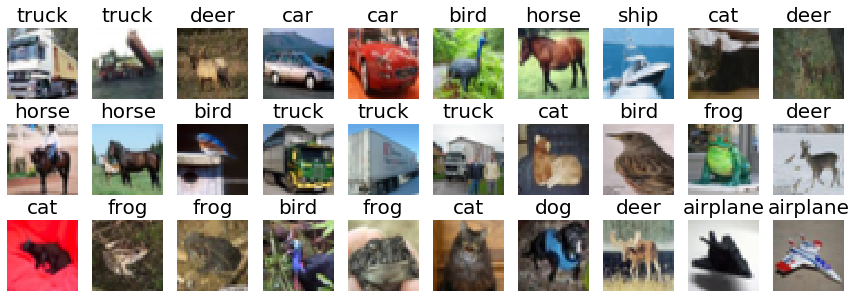

In [50]:
figure = plt.figure(figsize=(15,5))
for i in range(1,31):
    plt.subplot(3, 10, i)
    plt.axis('off')
#     plot_image(i, X_train, y_train)
    plt.imshow(X_train[i].transpose((1,2,0)))
    plt.title(classes[int(y_train[i])], fontsize=20)
figure.savefig("/results/cifar_example.pdf", bbox_inches='tight')

In [33]:
y_train[i]

array([9], dtype=uint8)